In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import json
import seaborn as sns
from collections import Counter

In [2]:
os.chdir('/shared/0/projects/research-jam-summer-2024')
df = pd.read_json('data/regression_100k_data/merged_metrics_with_dicts_397k.jsonl', orient='records', lines=True)

In [31]:
from copy import deepcopy
df1 = deepcopy(df)

In [32]:
url = "https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv"
country_region = pd.read_csv(url)
country_region.head()
import re
country_region.name = country_region.name.apply(lambda x: re.sub(',.*','',x))
country_region.loc[country_region['alpha-2']=='KP','name'] = 'South Korea'
country_region.loc[country_region['alpha-2']=='CD','name'] = 'DR Congo'
country_region.loc[country_region['name']=='Taiwan','region'] = 'Asia'
country_region.loc[country_region['name']=='Taiwan','sub-region'] = 'Eastern Asia'
df1.country = df1.country.replace({'United States':'United States of America',
                                 'Russia':'Russian Federation',
                                 'United Kingdom': 'United Kingdom of Great Britain and Northern Ireland',
                                 'The Netherlands': 'Netherlands',
                                 'Vietnam': 'Viet Nam',
                                 'Syria': 'Syrian Arab Republic',
                                 'Laos': "Lao People's Democratic Republic"})
df1 = df1.merge(country_region[['name','sub-region','region']], 
                left_on='country', right_on='name', how='left')
df1.loc[df1.country=='Kosovo','region'] = 'Europe'
df1.loc[df1.country=='Kosovo','sub-region'] = 'Southern Europe'
df1.loc[df1.country=='United States of America','sub-region'] = 'United States'
df1.loc[df1.country=='United States of America','region'] = 'United States'
df1 = df1.drop(['name','country','region'], axis=1)

Counter(df1['sub-region'])
df1.loc[df1['sub-region']=='Polynesia','sub-region'] = 'Melanesia'
Counter(df1['sub-region'])
df1 = df1.rename(columns={'sub-region':'subregion'})
df1.subregion = df1.subregion.replace({'Australia and New Zealand':'Oceania',
                       'Melanesia':'Oceania',
                       'Latin America and the Caribbean':'Latin America',
                      })
df1.subregion = df1.subregion.str.replace('Eastern ','E ').str.replace('Northern ','N ').str.replace('Western ','W ').str.replace('Southern ','S ').str.replace('South-eastern ','SE ')


In [33]:
# DROP UNNEEDED COLUMNS
df1 = df1.drop(['conversation_hash', 'hashed_ip', 'language',
                          'human_turn_1_liwc', 'human_turn_1_pos', 'human_turn_1_punctuation','human_turn_1_topic',
                          'ai_turn_2_liwc', 'ai_turn_2_pos', 'ai_turn_2_punctuation','ai_turn_2_topic'], axis=1)
df1['human_turn_1_perplexity'] = np.log(df1['human_turn_1_perplexity'])
df1['ai_turn_2_perplexity'] = np.log(df1['ai_turn_2_perplexity'])

In [34]:
# df2 has topic/category as categorical variables
# df1 has them as distributions (need to drop most common category)
df2 = deepcopy(df1)
df1 = df1.drop(['topic9','category_1'], axis=1)

In [35]:
# RELABEL TOPIC
df2['lda'] = df2.loc[:,df2.columns.str.startswith('topic')].idxmax(axis=1)
Counter(df2['lda'])
df2 = df2.loc[:,~df2.columns.str.startswith('topic')]
id2label = {
    'topic0': 'Story-Literature Club',
    'topic1': 'Roleplay setup-Teen Drama',
    'topic2': 'Jailbreak-Roleplay',
    'topic3': 'Story-Bathroom, Sexual',
    'topic4': 'Text-to-Image prompt-Scene',
    'topic5': 'Roleplay setup-Transgender',
    'topic6': 'Programming-Python, Data',
    'topic7': 'Story-Japanese Musician',
    'topic8': 'Story-Misc',
    'topic9': 'Information-Social Media',
    'topic10': 'Jailbreak-System',
    'topic11': 'Information-Mugs',
    'topic12': 'Text-to-Image prompt-Scene2',
    'topic13': 'Story-Superhero',
    'topic14': 'Jailbreak-RPG Spells',
    'topic15': 'Information-Philosophy/Physics',
    'topic16': 'Programming-Audio, Cloud, Math',
    'topic17': 'Story-Anime',
    'topic18': 'Programming-Java, App',
    'topic19': 'Programming-Social Media',
    'topic20': 'Programming-Front End',
    'topic21': 'Information-Business',
    'topic22': 'Jailbreak-Game Devs',
    'topic23': 'Story-Boyband',
    'topic24': 'Jailbreak-System2',
    'topic25': 'Jailbreak-Roleplay2',
    'topic26': 'Programming-Java, French',
    'topic27': 'Information-Asian History',
    'topic28': 'Information-Chemistry',
    'topic29': 'Multilingual-Asian',
    'topic30': 'Story-Misc2:',
    'topic31': 'Information-Online Content',
    'topic32': 'Jailbreak-System3',
    'topic33': 'Story-Movies',
    'topic34': 'Information-Model Usage',
    'topic35': 'Programming-ML/Data Science',
    'topic36': 'Programming-Misc',
    'topic37': 'Programming-Message Handling??',
    'topic38': 'Story-Comedic',
    'topic39': 'Story-Historical',
    'topic40': 'Multilingual-City Fiction??',
    'topic41': 'Story-Fan Fiction??',
    'topic42': 'Story-Pokémon Powers??',
    'topic43': 'General-??',
    'topic44': 'Text-to-Image prompt-Human',
    'topic45': 'General-Scene',
    'topic46': 'Story-Sci-Fi/Magic',
    'topic47': 'Story-Women/Fashion',
    'topic48': 'Story-Comedy Writing',
    'topic49': 'Story-Kids Shows',
}
df2.lda = df2.lda.replace(id2label)
df1 = df1.rename(columns = {k:"topic_"+v for k,v in id2label.items()})


In [36]:
# RELABEL CATEGORY
df2['category'] = df2.loc[:,df2.columns.str.contains('category_')].idxmax(axis=1)
Counter(df2['category'])
df2 = df2.loc[:,~df2.columns.str.contains('category_')]

label2id = {
    "analysis or decision explanation": 0,
    "assisting or creative writing": 1,
    "classification": 2,
    "coding": 3,
    "editing or rewriting": 4,
    "factual information (general or professional), history or common practices": 5,
    "information extraction or summarization": 6,
    "linguistics": 7,
    "logical reasoning": 8,
    "mathematical reasoning or calculation": 9,
    "multilinguality or translation": 10,
    "other": 11,
    "recommendation": 12,
    "roleplay": 13,
    "tips, opinions or advice": 14
  }
label2id = {
    "analysis": 0,
    "writing": 1,
    "classification": 2,
    "coding": 3,
    "editing": 4,
    "information": 5,
    "infoextraction": 6,
    "linguistics": 7,
    "logic": 8,
    "math": 9,
    "multilingual": 10,
    "other": 11,
    "recommendation": 12,
    "roleplay": 13,
    "tips": 14
  }
cats = {'category_'+str(label2id[k]): k for k in label2id}
len(cats)

df1 = df1.rename(columns = {k:'cat_'+v for k,v in cats.items()})
df2.category = df2.category.replace(cats)

/tmp/ipykernel_3917529/10314114.py:2: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df2['category'] = df2.loc[:,df2.columns.str.contains('category_')].idxmax(axis=1)


In [37]:
all_cols = df1.columns.tolist()
labels = [c for c in all_cols if c.startswith('agg_') or c.startswith('overall_')] #or c.startswith('metric_')]
labels

['agg_zscore_lexical',
 'agg_zscore_semantic',
 'agg_zscore_style',
 'agg_zscore_syntactic',
 'overall_zscore_score']

In [39]:
import re
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

labels = ['agg_zscore_lexical',
          'agg_zscore_syntactic',
          'agg_zscore_semantic',
          'agg_zscore_style',
          'overall_zscore_score']
result_data = []
import pandas as pd
from statsmodels.tools import add_constant
from statsmodels.api import OLS
from collections import Counter
for item in labels:
    vars_to_drop = ['lda_topic9', 'model_gpt-3.5-turbo-0301','country',
                    'llm_model_wildchat_subset_en_100k_Llama-3.1-70B', 'prompt_Prompt_11',
                    'subregion_United States', 'category_writing',
                    'human_turn_1_readability','ai_turn_2_readability', 'metric_end', 
                    'human_turn_1_formality', 'ai_turn_2_formality',
                    'human_turn_1_contract_count', 'ai_turn_2_contract_count', 'turn',
               ]
    vars_to_drop.extend([c for c in df1.columns if c.startswith('cat_')])
    vars_to_drop.extend(labels)
    vars_to_drop.remove(item)

    df_vif = pd.get_dummies(df1, dtype='int')
    df_vif = df_vif.drop([x for x in vars_to_drop if x in df_vif.columns], axis=1).dropna()
    df_vif.toxic = df_vif.toxic.apply(lambda x: 1 if x else 0)
    #df_vif['long_conversation'] = (df_vif.turn > 3).astype(int)
    #df_vif = df_vif.drop(['turn'], axis=1)
    for c in df_vif.columns:
        if len(Counter(df_vif[c]))<=1:
            df_vif = df_vif.drop([c], axis=1)
            print('removed',c)
    df_vif = add_constant(df_vif)

    X = df_vif.drop([item], axis=1)
    print(X.columns.tolist())

    y = df_vif[item]
    #print(item)

    mod = OLS(y, X)
    res = mod.fit()

    conf = res.conf_int(alpha=0.05/X.shape[1])
    print('p value threshold:', 0.05/X.shape[1])

    for variable in res.params.index:
        result_data.append({
            'Variable': variable,
            'Coefficient': res.params[variable],
            'P-value': res.pvalues[variable],
            'CI_Lower': conf.loc[variable, 0],
            'CI_Upper': conf.loc[variable, 1],
            'DV': item
        })

    res = res.summary(alpha=0.05/X.shape[1])
    print(res)
    print(f'written output of DV {item}')


output_file = 'data/output_regression_df1.csv'
results_df = pd.DataFrame(result_data)

results_df.to_csv(output_file, index=False)

print(f"OLS results @ '{output_file}'.")


['const', 'toxic', 'topic_Story-Literature Club', 'topic_Roleplay setup-Teen Drama', 'topic_Jailbreak-Roleplay', 'topic_Story-Bathroom, Sexual', 'topic_Text-to-Image prompt-Scene', 'topic_Roleplay setup-Transgender', 'topic_Programming-Python, Data', 'topic_Story-Japanese Musician', 'topic_Story-Misc', 'topic_Jailbreak-System', 'topic_Information-Mugs', 'topic_Text-to-Image prompt-Scene2', 'topic_Story-Superhero', 'topic_Jailbreak-RPG Spells', 'topic_Information-Philosophy/Physics', 'topic_Programming-Audio, Cloud, Math', 'topic_Story-Anime', 'topic_Programming-Java, App', 'topic_Programming-Social Media', 'topic_Programming-Front End', 'topic_Information-Business', 'topic_Jailbreak-Game Devs', 'topic_Story-Boyband', 'topic_Jailbreak-System2', 'topic_Jailbreak-Roleplay2', 'topic_Programming-Java, French', 'topic_Information-Asian History', 'topic_Information-Chemistry', 'topic_Multilingual-Asian', 'topic_Story-Misc2:', 'topic_Information-Online Content', 'topic_Jailbreak-System3', 'top

In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def calculate_vif(numeric_df):
#     numeric_df = dataframe#.select_dtypes(include=[np.number])
    
#     numeric_df = numeric_df.dropna()

#     numeric_df = add_constant(numeric_df)
    
    vif_data = pd.DataFrame()
    vif_data["Variable"] = numeric_df.columns
    vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, j) 
                       for j in range(numeric_df.shape[1])]
    
    print("VIF Values for each variable:")
    print(vif_data)
    print("\n")
    
    high_vif = vif_data[vif_data["VIF"] > 4]
    if not high_vif.empty:
        print("Variables with high multicollinearity (VIF > 10):")
        print(high_vif)
        return high_vif
    else:
        print("No variables with high multicollinearity detected.")

In [41]:
calculate_vif(X.sample(10000))

VIF Values for each variable:
                           Variable         VIF
0                             const  280.593956
1                             toxic    1.694525
2       topic_Story-Literature Club    1.065644
3   topic_Roleplay setup-Teen Drama    1.297864
4          topic_Jailbreak-Roleplay    1.461737
..                              ...         ...
87               subregion_S Europe    1.115642
88                subregion_SE Asia    1.212447
89     subregion_Sub-Saharan Africa    1.132797
90                 subregion_W Asia    1.218764
91               subregion_W Europe    1.306908

[92 rows x 2 columns]


Variables with high multicollinearity (VIF > 10):
  Variable         VIF
0    const  280.593956


,Variable,VIF
0,const,280.593956


The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


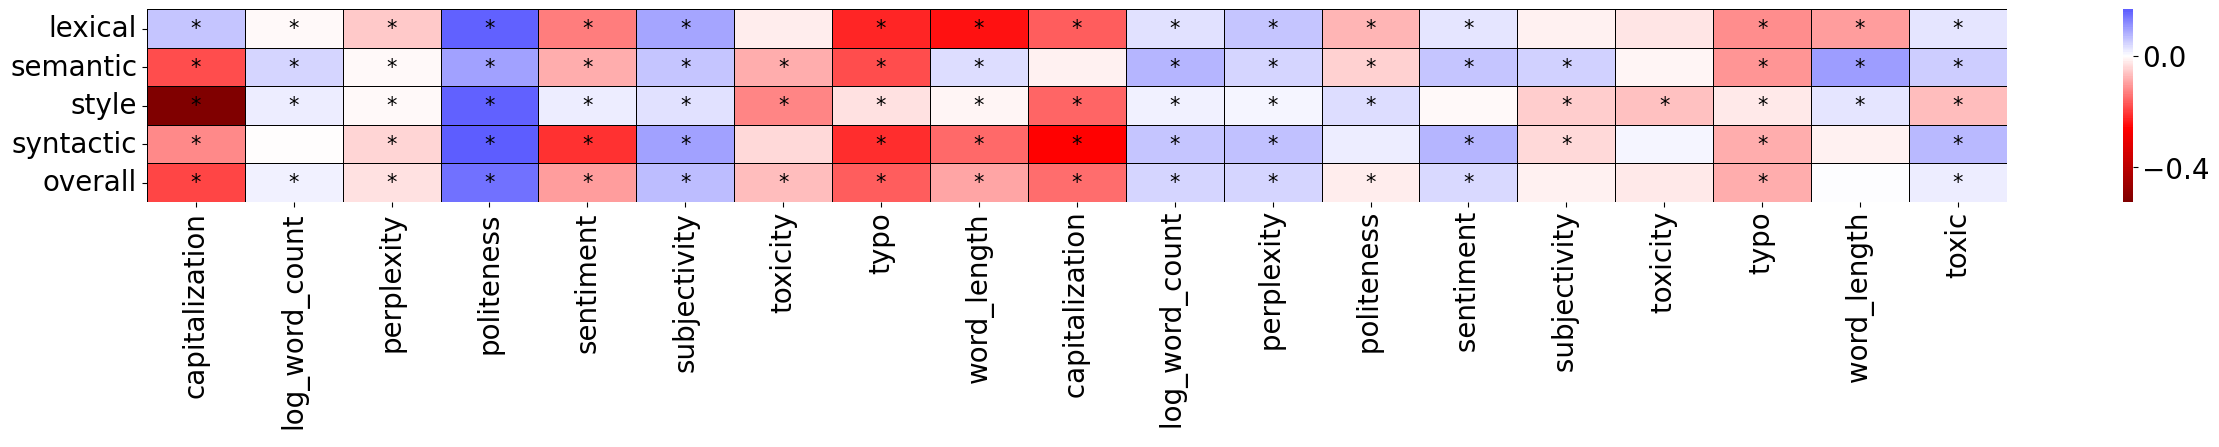

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

results_df = pd.read_csv('data/output_regression_df1.csv')

results_df = results_df[~results_df['Variable'].str.startswith(('topic', 
                                                                #'ai_turn_2', 'human_turn_1',
                                                                'prompt', 'subregion_', 'const', 
                                                                'model_', 'cat_', 'overall_', 'llm_model_'
))]

const_vars = results_df[results_df['Variable'].str.startswith('const')]['Variable'].unique()
human_turn_1_vars = results_df[results_df['Variable'].str.startswith('human_turn_1_')]['Variable'].unique()
ai_turn_2_vars = results_df[results_df['Variable'].str.startswith('ai_turn_2_')]['Variable'].unique()
subregion_vars = results_df[results_df['Variable'].str.startswith('subregion_')]['Variable'].unique()
remaining_vars = results_df[~results_df['Variable'].str.startswith(('const', 'human_turn_1_', 'ai_turn_2_', 'subregion_'))]['Variable'].unique()

ordered_vars = list(const_vars) + list(human_turn_1_vars) + list(ai_turn_2_vars) + list(subregion_vars) + list(remaining_vars)

matrix = results_df.pivot(index='DV', columns='Variable', values='Coefficient')
matrix = matrix[ordered_vars]

p_value_matrix = results_df.pivot(index='DV', columns='Variable', values='P-value')
p_value_matrix = p_value_matrix[ordered_vars]

def remove_prefixes(label):
    if label.startswith('human_turn_1_'):
        return label[len('human_turn_1_'):]
    elif label.startswith('ai_turn_2_'):
        return ' ' + label[len('ai_turn_2_'):]
    elif label.startswith('log_'):
        return ' ' + label[len('log_'):]
    elif label.startswith('model_'):
        return label[len('model_'):]
    elif label.startswith('subregion_'):
        return label[len('subregion_'):]
    elif label.startswith('agg_zscore_'):
        return label[len('agg_zscore_'):]
    elif label=='overall_zscore_score':
        return 'overall'
    else:
        return label

matrix.columns = [remove_prefixes(col) for col in matrix.columns]
p_value_matrix.columns = [remove_prefixes(col) for col in p_value_matrix.columns]
matrix.index = [remove_prefixes(idx) for idx in matrix.index]
p_value_matrix.index = [remove_prefixes(idx) for idx in p_value_matrix.index]

cmap = 'seismic_r'

val = 0.05 / 110
mask = p_value_matrix <= val

plt.rcParams.update({'font.size': 50, 'axes.titlesize': 20, 'axes.labelsize': 18, 'xtick.labelsize': 20, 'ytick.labelsize': 20})
plt.figure(figsize=(30, 2.5)) 

ax = sns.heatmap(matrix, annot=False, cmap=cmap, center=0, linewidths=0.5, linecolor='black', cbar_kws=dict(ticks=[-.4, 0, .4]))

for (i, j), val in np.ndenumerate(mask):
    if val:
        ax.text(j + 0.5, i + 0.5, '*', color='black', 
                ha='center', va='center', fontsize=15, zorder=3)

#plt.title('Heatmap of Coefficients Grouped by DV and Variable (* indicates p-value < 0.0004)')
plt.xlabel('')
plt.ylabel('')

#plt.savefig('heatmap-regression.pdf', bbox_inches='tight')
plt.show()


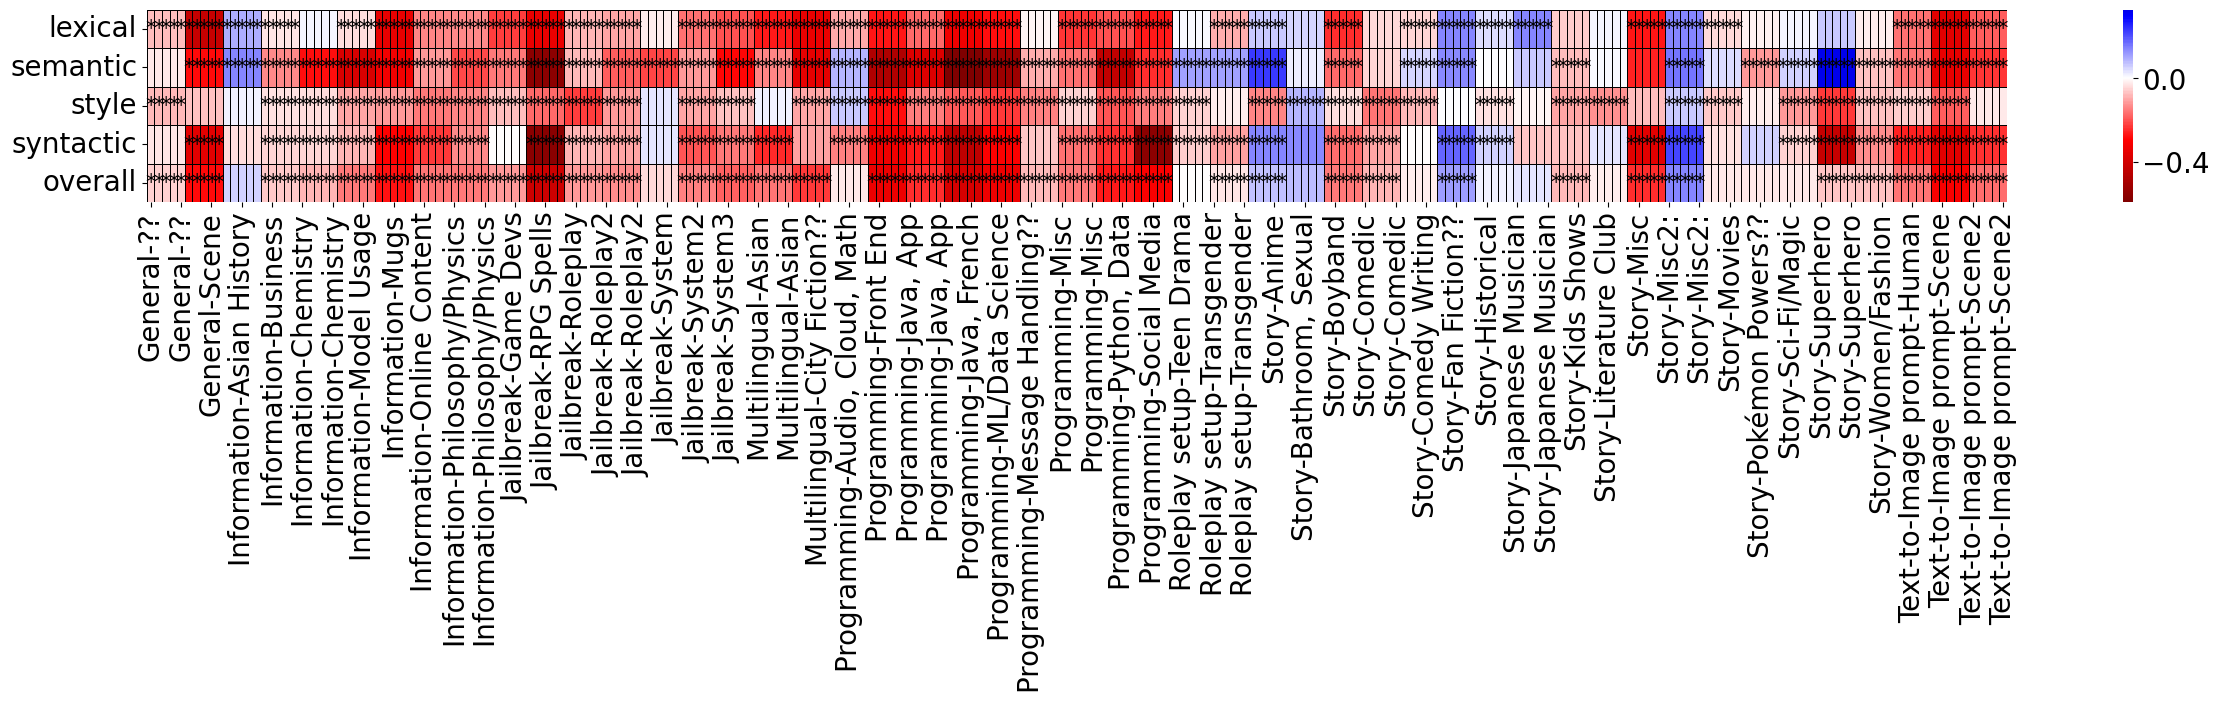

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

results_df = pd.read_csv('data/output_regression_df1.csv')

results_df = results_df[~results_df['Variable'].str.startswith((#'topic', 
                                                                'ai_turn_2', 'human_turn_1',
                                                                'prompt', 'subregion_', 'const', 'toxic',
                                                                'model_', 'cat_', 'overall_', 'llm_model_'
))]

ordered_vars = sorted(results_df['Variable'].tolist())

matrix = results_df.pivot(index='DV', columns='Variable', values='Coefficient')
matrix = matrix[ordered_vars]

p_value_matrix = results_df.pivot(index='DV', columns='Variable', values='P-value')
p_value_matrix = p_value_matrix[ordered_vars]

def remove_prefixes(label):
    if label.startswith('topic_'):
        return label[len('topic_'):]
    elif label.startswith('agg_zscore_'):
        return label[len('agg_zscore_'):]
    elif label=='overall_zscore_score':
        return 'overall'
    else:
        return label

matrix.columns = [remove_prefixes(col) for col in matrix.columns]
p_value_matrix.columns = [remove_prefixes(col) for col in p_value_matrix.columns]
matrix.index = [remove_prefixes(idx) for idx in matrix.index]
p_value_matrix.index = [remove_prefixes(idx) for idx in p_value_matrix.index]

cmap = 'seismic_r'

val = 0.05 / 110
mask = p_value_matrix <= val

plt.rcParams.update({'font.size': 50, 'axes.titlesize': 20, 'axes.labelsize': 18, 'xtick.labelsize': 20, 'ytick.labelsize': 20})
plt.figure(figsize=(30, 2.5)) 

ax = sns.heatmap(matrix, annot=False, cmap=cmap, center=0, linewidths=0.5, linecolor='black', cbar_kws=dict(ticks=[-.4, 0, .4]))

for (i, j), val in np.ndenumerate(mask):
    if val:
        ax.text(j + 0.5, i + 0.5, '*', color='black', 
                ha='center', va='center', fontsize=15, zorder=3)

#plt.title('Heatmap of Coefficients Grouped by DV and Variable (* indicates p-value < 0.0004)')
plt.xlabel('')
plt.ylabel('')

#plt.savefig('heatmap-regression.pdf', bbox_inches='tight')
plt.show()
